E-commerce Retail Analytics (RFM & Segmentation)

[Dataset link](https://www.kaggle.com/datasets/carrie1/ecommerce-data)

In [218]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [219]:
df = pd.read_csv('data.csv', encoding='iso-8859-1')

In [220]:
df.count()

,0
InvoiceNo,541909
StockCode,541909
Description,540455
Quantity,541909
InvoiceDate,541909
UnitPrice,541909
CustomerID,406829
Country,541909


In [221]:
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,12/1/2010 8:26,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,12/1/2010 8:26,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,12/1/2010 8:26,3.39,17850.0,United Kingdom


In [222]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   InvoiceNo    541909 non-null  object 
 1   StockCode    541909 non-null  object 
 2   Description  540455 non-null  object 
 3   Quantity     541909 non-null  int64  
 4   InvoiceDate  541909 non-null  object 
 5   UnitPrice    541909 non-null  float64
 6   CustomerID   406829 non-null  float64
 7   Country      541909 non-null  object 
dtypes: float64(2), int64(1), object(5)
memory usage: 33.1+ MB


In [223]:
cancelled= df['InvoiceNo'].astype(str).str.startswith('C')

number_of_canceled_orders = cancelled.sum()

print(f"Total number of canceled orders: {number_of_canceled_orders}")
# to show the number of cancelled orders(orders where the invoice begins with C)

Total number of canceled orders: 9288


In [224]:
# boolean mask where the condition is True for invalid transactions
invalid_transaction = (df['Quantity'] <= 0) | (df['UnitPrice'] <= 0)

# count the number of rows that satisfy the condition
number_of_invalid_transactions = invalid_transaction.sum()

print(f"Total number of line items where Quantity or UnitPrice is zero/negative: {number_of_invalid_transactions}")

Total number of line items where Quantity or UnitPrice is zero/negative: 11805


In [225]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   InvoiceNo    541909 non-null  object 
 1   StockCode    541909 non-null  object 
 2   Description  540455 non-null  object 
 3   Quantity     541909 non-null  int64  
 4   InvoiceDate  541909 non-null  object 
 5   UnitPrice    541909 non-null  float64
 6   CustomerID   406829 non-null  float64
 7   Country      541909 non-null  object 
dtypes: float64(2), int64(1), object(5)
memory usage: 33.1+ MB


Type error:
- The Dtype for CustomerID is float64, ID's should always be integers.
- InvoiceDate should be converted to DateTime format

Missing values:
- Description column has some missing values
- CustomerID has about 130k missing values
- Description has some missing values



Actions to take
- Drop all rows that have essential data(customerid) missing as they will be useless for sales and rfm analysis
- Description is missing in some rows, but those rows still have valid CustomerID, Quantity, and UnitPrice. Since the missing values do not affect revenue or RFM calculations, we  will keep them
- convert the object/float columns to their correct types.
- remove order cancellations (starting with 'C'),9288 of them and invalid transactions (transactions where quantity or Price is zero/negative)11k+ of them



In [226]:
# Drop all rows where the critical columns are missing
# fixes the missing CustomerIDs and the single row missing Quantity/Date/Price.
df.dropna(subset=['CustomerID'], inplace=True)

In [227]:
# Convert InvoiceDate from object (string) to datetime
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'])

#Convert CustomerID from float to integer.
df['CustomerID'] = df['CustomerID'].astype(int)

In [228]:
# Remove canceled orders
df = df[~df['InvoiceNo'].astype(str).str.startswith('C')]

# Remove transactions where Quantity or UnitPrice is invalid
df = df[(df['Quantity'] > 0) & (df['UnitPrice'] > 0)]

# 6. Create 'Sales' column for analysis
df['Sales'] = df['Quantity'] * df['UnitPrice']

In [229]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 397884 entries, 0 to 541908
Data columns (total 9 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   InvoiceNo    397884 non-null  object        
 1   StockCode    397884 non-null  object        
 2   Description  397884 non-null  object        
 3   Quantity     397884 non-null  int64         
 4   InvoiceDate  397884 non-null  datetime64[ns]
 5   UnitPrice    397884 non-null  float64       
 6   CustomerID   397884 non-null  int64         
 7   Country      397884 non-null  object        
 8   Sales        397884 non-null  float64       
dtypes: datetime64[ns](1), float64(2), int64(2), object(4)
memory usage: 30.4+ MB


RFM ANALYSIS(Recency, Frequency, Monetary Analysis)



1.  **The transaction data will be aggregated by each unique customer to determine:**

- Recency (R): When was the last time the customer made a purchase? This is number of days between the date of the oldest transaction and the customer's most recent purchase date

- Frequency (F): How often do they buy? (Number of unique invoices).

- Monetary (M): How much have they spent in total?

2.   **Calculating RFM scores**
- Recency:  Customers with the lowest Recency value get Score 5.

- Frequency:  Customers with the highest Frequency value get Score 5.

- Monetary: Customers with the highest Monetary value get Score 5.

3. **Segment customers**
-  '01'. Best customers: score 5 across all RFM metrics, these customers will be rewarded(loyalty coupons etc), they will be prioritised for new product launches

-  '04'. New customers: score 4x1, 5x1, 51x across all RFM metrics. Welcome them with a personalized onboarding experience that helps them come back often

-  '05'. Potentially at risk customers: 233 to 333 across all RFM metrics. Try to win them back using discounts etc.

-  '06'. Lost customers: 111 or 12x across RFM metrics. attempt a retention campaign, or just save marketing resources lol

Not all segments have been listed here, but just go with it lol

In [230]:
#check the latest date
# add one day to make sure Recency calculation is correct.
latest_date = df['InvoiceDate'].max() + pd.Timedelta(days=1)

In [231]:
# Calculate R, F, and M metrics for each Customerid
rfm_df = df.groupby('CustomerID').agg(
    # Recency
    Recency=('InvoiceDate', lambda x: (latest_date - x.max()).days),

    # Frequency
    Frequency=('InvoiceNo', 'nunique'),

    # Monetary (M): Sum the total sales (the 'Sales' column created earlier)
    Monetary=('Sales', 'sum')
)


rfm_df.head()

,Recency,Frequency,Monetary
CustomerID,,,
12346,326,1,77183.60
12347,2,7,4310.00
12348,75,4,1797.24
12349,19,1,1757.55
12350,310,1,334.40


In [232]:
# --- Calculate RFM Scores
rfm_df['R_Score'] = pd.qcut(
    rfm_df['Recency'],
    q=5,
    labels=False,
    duplicates='drop'
) + 1

rfm_df['F_Score'] = pd.qcut(
    rfm_df['Frequency'],
    q=5,
    labels=False,
    duplicates='drop'
) + 1

rfm_df['M_Score'] = pd.qcut(
    rfm_df['Monetary'],
    q=5,
    labels=False,
    duplicates='drop'
) + 1

# Combine scores into a single string
rfm_df['RFM_Score'] = rfm_df['R_Score'].astype(str) + rfm_df['F_Score'].astype(str) + rfm_df['M_Score'].astype(str)


In [233]:
rfm_df[['R_Score', 'F_Score', 'M_Score', 'RFM_Score']].head()


,R_Score,F_Score,M_Score,RFM_Score
CustomerID,,,,
12346,5,1,5,515
12347,1,4,5,145
12348,4,3,4,434
12349,2,1,4,214
12350,5,1,2,512


In [234]:
# Define customer segments based on R, F, and M scores
def rfm_segment(row):
    # R=5, F=5, M=5: Best customers, bought recently, buy often, spend the most
    if row['R_Score'] == 5 and row['F_Score'] == 5 and row['M_Score'] == 5:
        return '01. Best Customers'
    # R=4/5, F=4/5: Loyal customers
    elif (row['R_Score'] >= 4) and (row['F_Score'] >= 4):
        return '02. Loyal Customers'
    # M=4/5 and R=4/5 or F=4/5: Customers who spend a lot but not necessarily frequently
    elif (row['M_Score'] >= 4) and (row['R_Score'] >= 4 or row['F_Score'] >= 4):
        return '03. Big Spenders'
    # R=4/5, F=1/2: Purchased recently, but not frequently (new or one-time buyers)
    elif (row['R_Score'] >= 4) and (row['F_Score'] <= 2):
        return '04. New Customers'
    # R=2/3, F=3/4, M=3/4: Customers who haven't bought in a while, but used to be good spenders
    elif (row['R_Score'] >= 2) and (row['F_Score'] >= 3):
        return '05. Potentially At Risk'
    # R=1/2, F=1/2: Haven't bought recently, don't buy often.
    elif (row['R_Score'] <= 2) and (row['F_Score'] <= 2):
        return '06. Lost Customers'
    # All others
    else:
        return '07. Others'

In [235]:
rfm_df['Segment'] = rfm_df.apply(rfm_segment, axis=1)

In [236]:
# Count customers and revenue in each segment
segment_summary = rfm_df.groupby('Segment').agg(
    Total_Revenue=('Monetary', 'sum'),
    Average_Monetary=('Monetary', 'mean'),
    Average_Recency=('Recency', 'mean')
)

# Get the total number of customers separately by using the size() function.
segment_summary.insert(0, 'Total_Customers', rfm_df.groupby('Segment').size())
segment_summary = segment_summary.sort_values(by='Total_Customers', ascending=False)


In [237]:
segment_summary

,Total_Customers,Total_Revenue,Average_Monetary,Average_Recency
Segment,,,,
04. New Customers,1311,453449.912,345.880940,208.005339
03. Big Spenders,960,6076776.531,6329.975553,56.843750
07. Others,816,761358.390,933.037243,40.408088
06. Lost Customers,737,679086.020,921.419294,17.572592
05. Potentially At Risk,479,820930.301,1713.841965,49.158664
02. Loyal Customers,35,119806.750,3423.050000,133.914286


**VISUALIZE THE RESULTS**

The size and value of each customer segment will be demonstrated visually.


1. Segment Size
This will show the number of customers in each segment, this will give a clearer view of where majority of the customer base reside.

- Insight: Highlights the proportion of your customers that are 'best customers' versus those who are 'Lost' or 'New.'

- Action: It helpss to make sure that marketing effort allocation is proportional to the size of the segment its targeting.

- Method: A bar plot of Total_Customers vs. the Segment.

2. Revenue Contribution
This chart helps us understand the monetary value of each segment, it illsutrates the Pareto Principle (80% of revenue comes from 20% of customers).

- Insight: Identifies the highest-value segments ('Best customers' and 'Loyal Customers').

- Action: Confirms where retention efforts should be focused (the segments that contribute the largest slice of the pie chart).

- Method: Pie chart of Total_Revenue vs. Segment.


**INTERPRETATIONAND BUSINESS RECOMMENDATIONS**

Translate and communicate  findings into marketing strategies






/tmp/ipython-input-1936683006.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


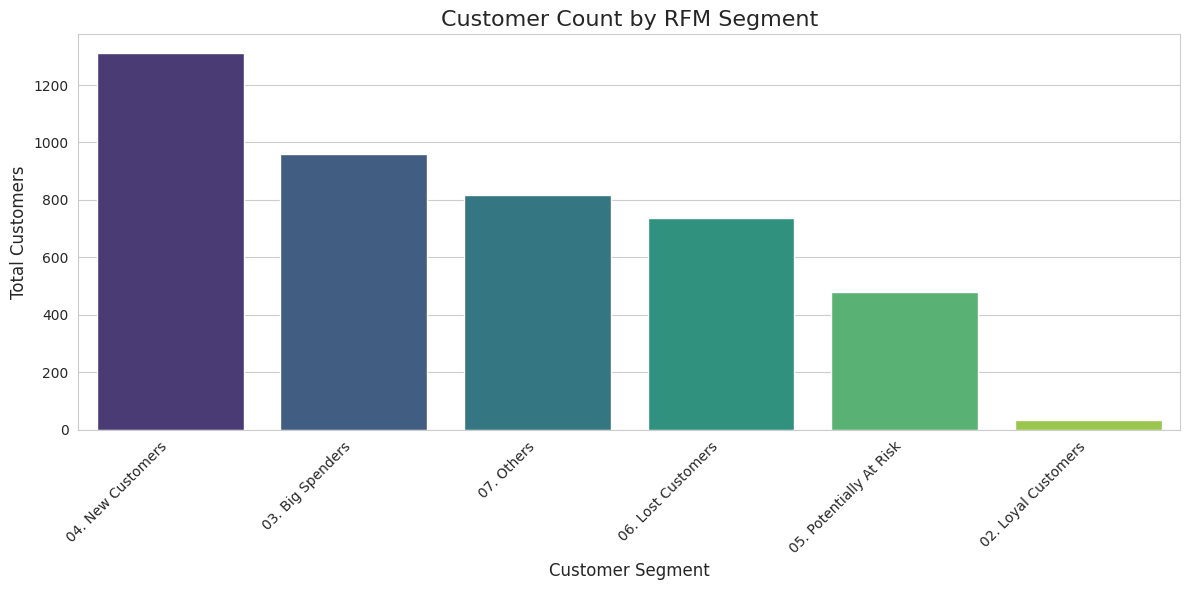

In [238]:
sns.set_style("whitegrid")
plt.figure(figsize=(12, 6))

sns.barplot(
    x=segment_summary.index,
    y='Total_Customers',
    data=segment_summary,
    palette='viridis'
)

plt.title('Customer Count by RFM Segment', fontsize=16)
plt.xlabel('Customer Segment', fontsize=12)
plt.ylabel('Total Customers', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

This chart shows that most customers are new, with a good number of big spenders coming in, this a clear sign that marketing and acquisition efforts are paying off. But only a few customers have become loyal, this shows that more attention should be paid to customerretention. There's also quite a few customers who are at risk of leaving. To fix this, re-engagement campaigns and loyalty programs that keep customers coming back should be put in place. In summary, This company is good at attracting new faces, but there’s a big opportunity to turn those first-time buyers into long-term supporters.


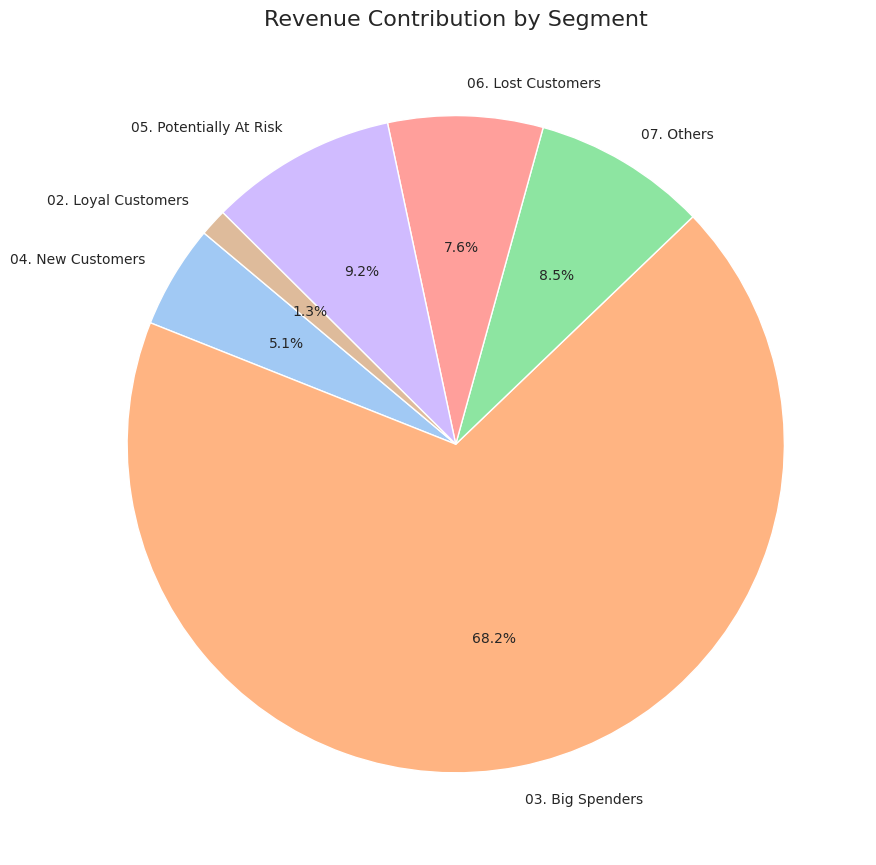

In [239]:
# Create a Pie Chart for Revenue
plt.figure(figsize=(9, 9))

# Select only segments that contribute significant revenue
revenue_shares = segment_summary[segment_summary['Total_Revenue'] > segment_summary['Total_Revenue'].sum() * 0.01]

plt.pie(
    revenue_shares['Total_Revenue'],
    labels=revenue_shares.index,
    autopct='%1.1f%%',
    startangle=140,
    colors=sns.color_palette('pastel')
)

plt.title('Revenue Contribution by Segment', fontsize=16)
plt.tight_layout()
plt.show()

The revenue breakdown shows that most income (nearly 70%) comes from a single group: the Big Spenders. This is good news in terms of high-value customers, but it also means our revenue is heavily dependent on a small segment. The rest of the groups contributebut its little, with “Potentially At Risk” and “Others” bringing in some steady revenue, and “Lost Customers” still adding a small share from past purchases. New and Loyal Customers account for only a tiny portion of the total revenue, which shows that new buyers aren’t spending much yet and loyalty isn’t translating into significant sales. Strengthening retention and loyalty programs could help to balance this dependence on Big Spenders and make revenue more sustainable in the long run.
